In [1]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

AUTOTUNE = tf.data.AUTOTUNE

# Load Food-101 dataset (TFDS)
dataset_name = "food101"
(ds_train, ds_test), dataset_info = tfds.load(
    dataset_name,
    split=["train", "validation"],
    as_supervised=True,
    # Load the dataset again (it will reuse the already downloaded and prepared data)
    # data_dir='/root/tensorflow_datasets'  # Optional: specify the directory for TFDS
    with_info=True
)
print("Dataset Loaded and Reused:", dataset_name)

# Récupérer les noms des classes
class_names = dataset_info.features['label'].names[:10]

num_classes = len(class_names)

# Convert class names to indices for filtering
selected_class_indices = {i: i for i in range(num_classes)}


# Function to filter
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, list(selected_class_indices.keys())))

ds_train_filtered = ds_train.filter(filter_classes)
ds_test_filtered = ds_test.filter(filter_classes)


# Preprocessing Function (Resizing & Normalisation)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalisation [0,1]
    return image, label

# Apply preprocessing
ds_train_preprocessed = ds_train_filtered.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test_preprocessed = ds_test_filtered.map(preprocess, num_parallel_calls=AUTOTUNE)

# Batch et préfetch des données
batch_size = 64
train_ds = ds_train_preprocessed.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = ds_test_preprocessed.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Activer l'entraînement en précision mixte
mixed_precision.set_global_policy('mixed_float16')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SU8SFH_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SU8SFH_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Dataset Loaded and Reused: food101


In [3]:
# Cnn model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation="relu", kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(len(class_names), activation="softmax", dtype='float32')  # dtype='float32' to avoid errors Mixed Precision
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [5]:
# Display the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 718,378 (2.74 MB)

 Trainable params: 715,434 (2.73 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [6]:
# Callbacks to get a better training
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training of the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[lr_scheduler] #early_stopping
)
model.save("cnn_food101_10classes__v2.h5")

print("model save under 'cnn_food101_10classes.h5'")

Epoch 1/60
    118/Unknown 58s 236ms/step - accuracy: 0.2366 - loss: 2.4372

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 329ms/step - accuracy: 0.2370 - loss: 2.4352 - val_accuracy: 0.1528 - val_loss: 3.1297 - learning_rate: 0.0010
Epoch 2/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.3540 - loss: 1.9104 - val_accuracy: 0.1412 - val_loss: 3.4990 - learning_rate: 0.0010
Epoch 3/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.4126 - loss: 1.6902 - val_accuracy: 0.1832 - val_loss: 3.5515 - learning_rate: 0.0010
Epoch 4/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.4681 - loss: 1.5417 - val_accuracy: 0.2908 - val_loss: 2.3785 - learning_rate: 0.0010
Epoch 5/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.5048 - loss: 1.4233 - val_accuracy: 0.4116 - val_loss: 1.8074 - learning_rate: 0.0010
Epoch 6/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.5311 - loss: 1.3300 - val_accuracy: 0.4732 - val_loss: 1.5828 - learning_rate: 0.0010
Epoch 7/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.5613 - loss:

model save under 'cnn_food101_10classes.h5'


In [7]:
# Evaluate the model on the validation dataset
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7314 - loss: 1.0470

Validation Accuracy: 72.16%

Validation Loss: 1.0641


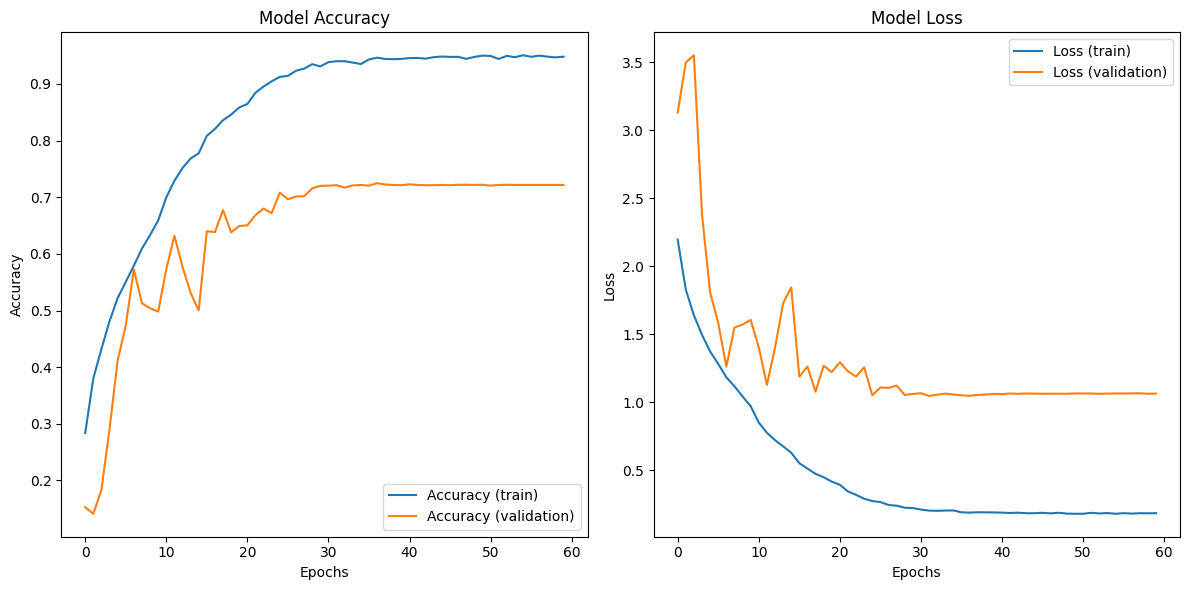

In [8]:
import matplotlib.pyplot as plt
# Plots of loss and accuracy
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(12, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy (train)')
plt.plot(val_acc, label='Accuracy (validation)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss (train)')
plt.plot(val_loss, label='Loss (validation)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.4734    0.3560    0.4064       250
   baby_back_ribs     0.8585    0.7280    0.7879       250
          baklava     0.6321    0.8040    0.7077       250
   beef_carpaccio     0.8321    0.8720    0.8516       250
     beef_tartare     0.6958    0.8600    0.7692       250
       beet_salad     0.8865    0.6560    0.7540       250
         beignets     0.7373    0.9320    0.8233       250
         bibimbap     0.8880    0.8560    0.8717       250
    bread_pudding     0.5445    0.6360    0.5867       250
breakfast_burrito     0.7288    0.5160    0.6042       250

         accuracy                         0.7216      2500
        macro avg     0.7277    0.7216    0.7163      2500
     weighted avg     0.7277    0.7216    0.7163      2500



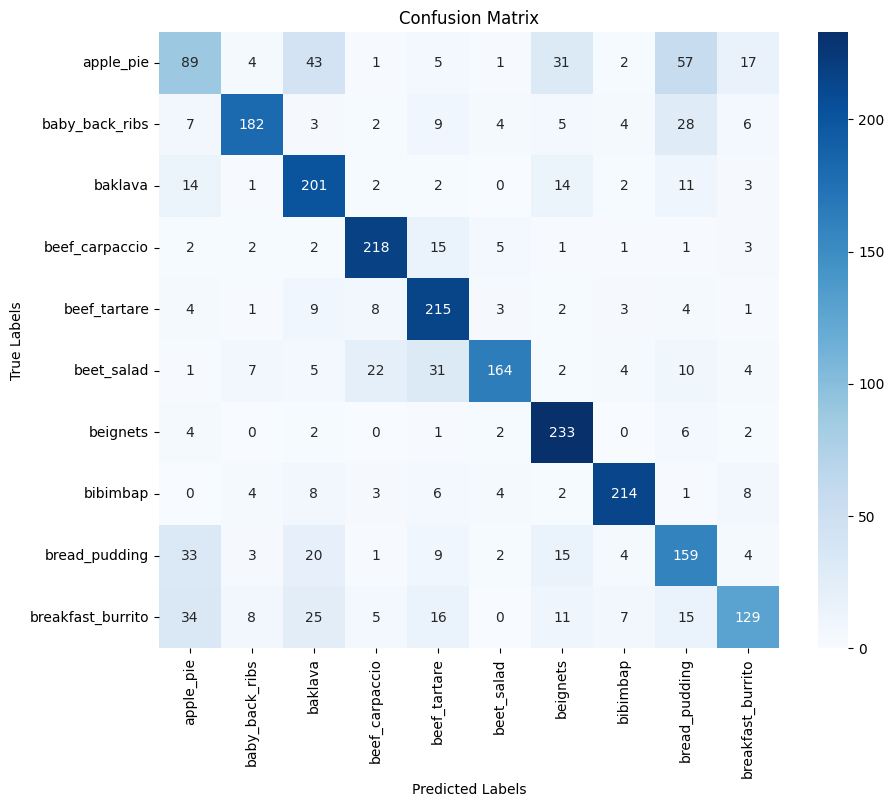

In [10]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import pandas as pd

# classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

# dataframe
df = pd.DataFrame(report_dict).transpose()

# saving
df.to_csv("classification_report.csv", index=True)

print("done under 'classification_report.csv'")


done under 'classification_report.csv'


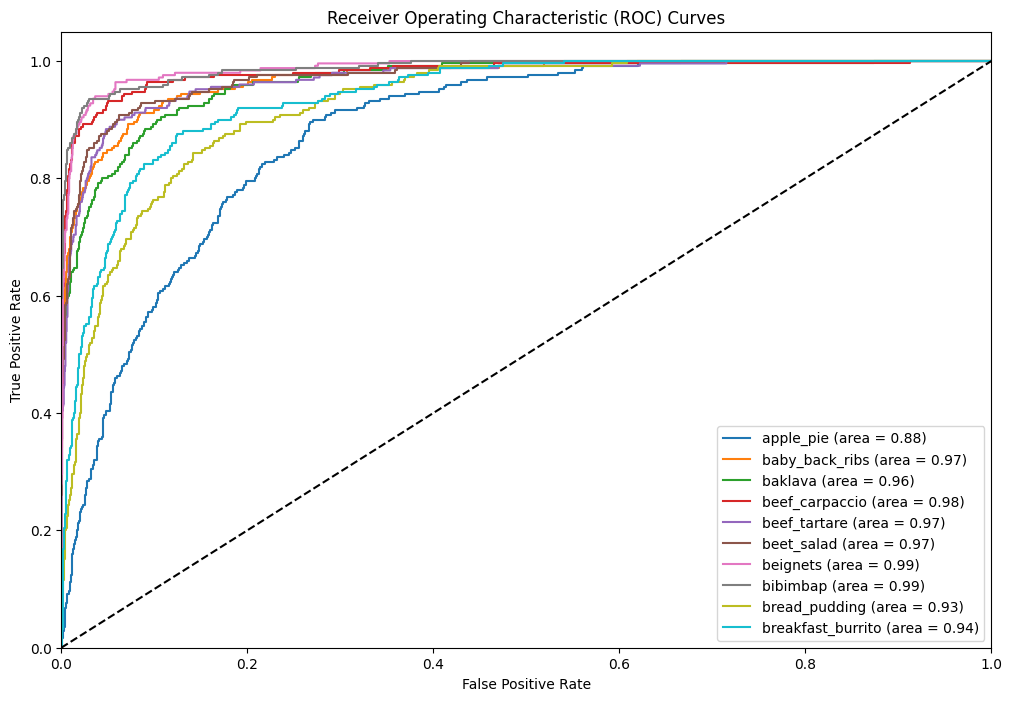

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))
n_classes = y_true_binarized.shape[1]

# Plot ROC for each class
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
